In [1]:
from functions import *
from scipy.optimize import curve_fit
def fitpowerlaw(x,y,deg):
    def powerlaw(x,coeff):
        return coeff*x**deg
    popt, _ = curve_fit(f=powerlaw, xdata=x, ydata=y)
    return popt

0.1904106589900121 3503786.938457903


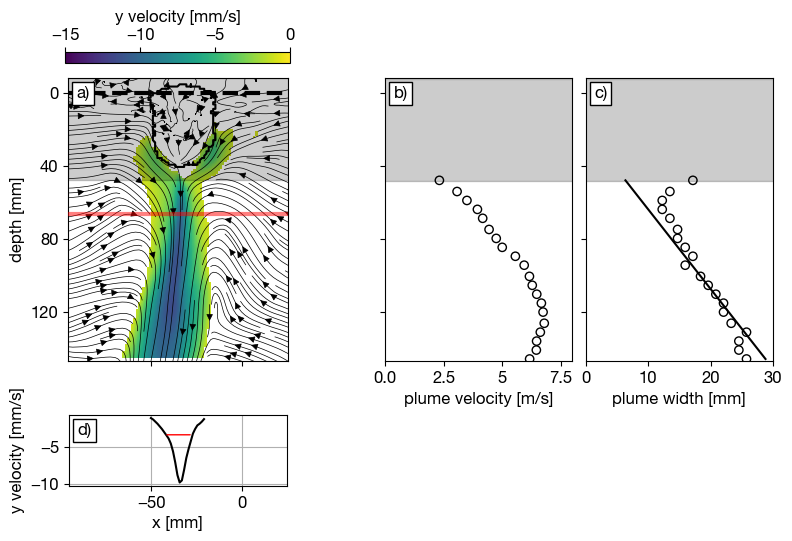

In [162]:
pivDirectory = '/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/2023-12-06/'
# chosen_salt,chosen_radius,chosen_time = 0.,0.025,'112113'#fresh 50mm
chosen_salt,chosen_radius,chosen_time = 35.,0.025,'111510'# salty 50mm
# chosen_salt,chosen_radius,chosen_time = 10.,0.0405,'095126' #salty 81mm
# chosen_salt,chosen_radius,chosen_time = 0.,0.025,'112901'#fresh 50mm

it=-1
folders = []

for folder in glob.glob(pivDirectory+'Cam*'):
    folders.append(folder)
folders = np.sort(folders)

for folder in folders:
    date = folder[93:99]
    time = str(folder[105:111])
    exp_sal = float(folder[113:115])
    exp_radius = int(folder[116:118])/2000
    if exp_radius == 0.006: exp_radius=0.06
    if exp_radius==chosen_radius and exp_sal==chosen_salt and time==chosen_time:
        it +=1
        # read data
        pivData = np.genfromtxt(glob.glob(folder+'/*.txt')[0]).T
        break
    # if it==4:break

x,y,u,v = pivData
# u = np.ma.array(u, mask=mask) # ONLY IF MASK EXISTS
side = np.sqrt(x.shape[0]).astype(int)


# regularly spaced grid spanning the domain of x and y 
xi = np.linspace(x.min(), x.max(), side)
yi = np.linspace(y.min(), y.max(), side)
X,Y = np.meshgrid(xi,yi)

ui = np.reshape(u,(side,side))[::-1,:]
vi = np.reshape(v,(side,side))[::-1,:]

for ic,contourPATH in enumerate(glob.glob(folder+'/*.csv')):
    contour = np.genfromtxt(contourPATH,dtype='float',delimiter=',')
    if contour.shape[1]!=2: contour = contour.T
indexMinimum = np.min(-(contour/1024*128)[:,1].astype(int))-6 # location of bottom of ice, shifted down to go further from the ice

fig,axs = plt.subplot_mosaic([['a)','b)','c)'],['d)','.','.']],figsize=(8,5.3),
                             width_ratios=[1,0.5,0.5],
                             height_ratios=[1,0.25],
                             layout='constrained')

ax0 = axs['a)']
cleanVi = np.where(vi>-0.001,np.nan,vi)
im = ax0.imshow(cleanVi*1000,extent=(xi[0],xi[-1],yi[-1],yi[0]),vmin=-15,vmax=0)
ax0.hlines(yi[indexMinimum-15],xi[0],xi[-1],colors='red',alpha = 0.5,linestyles='-',linewidth=3,
           zorder=100)
pc = contour/1024*128 # plot contour
ax0.plot(xi[pc[:,0].astype(int)],yi[-pc[:,1].astype(int)],c='k')
ax0.hlines(yi[(findWL(-pc)).astype(int)],xi[0],xi[-1],colors='k',linestyles='--',linewidth=3,label='water level')
fig.colorbar(im,label='y velocity [mm/s]',ax=axs['a)'],location='top',shrink=.6)
ax0.fill_between(np.linspace(xi[0],xi[-1],50),yi[indexMinimum],yi[-1],color='k',alpha=0.2)
ax0.streamplot(X,Y,ui,vi,color='black',linewidth=.5,density=2)
ax0.invert_yaxis()
ax0.set(xlabel='',ylabel='depth [mm]',
        xticklabels='',
        yticks=[-100,-60,-20,20],yticklabels=[120,80,40,0],
        xlim=(xi[0],25),
        ylim=(yi[0],yi[-1]),)

ax1 = axs['d)']
velocityProfile = cleanVi[indexMinimum-15,:]*1000
ax1.plot(xi,velocityProfile,c='k')
# plumeVel = np.nanmean(velocityProfile)
plumeVel = np.nansum(velocityProfile)/(np.sum(~np.isnan(velocityProfile))*(xi[1]-xi[0]))
left, right = np.where(np.abs(np.gradient(np.sign(velocityProfile-plumeVel)))==1)[0][0],np.where(np.abs(np.gradient(np.sign(velocityProfile-plumeVel)))==1)[0][-1]
b = abs(xi[left]-xi[right])
# ax1.hlines(plumeVel,xi[left],xi[right],colors='red')
ax1.annotate(xy=(xi[left],plumeVel),xytext=(xi[right],plumeVel),text='',
             arrowprops=dict(arrowstyle='-',color='red'))
ax1.grid()
ax1.set(xlim=(xi[0],25),
        title = '',#f'z = {yi[indexMinimum]:.2f} mm',
        xlabel='x [mm]',ylabel='y velocity [mm/s]',
        aspect=4.1)


ws = np.array([])
bs = np.array([])
zs = np.array([])

for _,iz in enumerate(np.linspace(-len(yi)+1,indexMinimum,20,dtype=int)):
    # print(iz,yi[iz])
    velocityProfile = cleanVi[iz,:]*1000
    w = np.nanmean(cleanVi[iz,:]*1000)
    # w = np.nansum(velocityProfile)/(np.sum(~np.isnan(velocityProfile))*(xi[1]-xi[0]))
    left, right = np.where(np.abs(np.gradient(np.sign(velocityProfile-w)))==1)[0][0],np.where(np.abs(np.gradient(np.sign(velocityProfile-w)))==1)[0][-1]
    # test
    # plt.title(yi[iz])
    # plt.plot(xi,velocityProfile)
    # plt.plot(xi,np.abs(np.gradient(np.sign(velocityProfile-w))))
    # plt.hlines(w,xi[left],xi[right],colors='red')
    # plt.grid()
    # plt.show()
    b = abs(xi[left]-xi[right])
    zs = np.append(zs,yi[iz])
    bs = np.append(bs,b)
    ws = np.append(ws,w)

ax2 = axs['b)']
ax2.scatter(-ws,-zs,facecolor='none',edgecolor='k')
# ax1.plot(fitpowerlaw(x=-zs,y=-ws,deg=-1/3)*np.linspace(40,120,50)**(-1/3),
#          np.linspace(40,120,50),)
ax3 = axs['c)']
ax3.scatter(bs,-zs,facecolor='none',edgecolor='k')
ax3.plot(fitpowerlaw(zs,bs,1)*zs,-zs,c='k')
alpha = -5*fitpowerlaw(zs,bs,1)[0]/6
B = (fitpowerlaw(x=zs-np.min(zs)+1,y=-ws,deg=-1/3)[0]*6/5/alpha)**3*10/9/alpha
print(alpha,B)
for axi in [ax2,ax3]:
    axi.set(ylim=(-yi[-1],-yi[0]),
            yticks=[100,60,20,-20],yticklabels='',)
    axi.invert_yaxis()
    axi.fill_between(np.linspace(xi[0],xi[-1],50),yi[indexMinimum],yi[-1],color='k',alpha=0.2)
ax2.set(xlabel='plume velocity [m/s]',
        xlim=(0,8),
        xticks=[0.,2.5,5,7.5],xticklabels=[0.,2.5,5,7.5])
ax3.set(xlabel='plume width [mm]',
        xlim=(0,30),)

for label,axi in axs.items():
    axi.annotate(
        label,
        xy=(0, 1), xycoords='axes fraction',
        xytext=(+0.5, -0.5), textcoords='offset fontsize',
        verticalalignment='top',
        bbox=dict(facecolor='white', edgecolor='k', pad=3.0))

plt.savefig('/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/graphics/plumeCharacteristics.pdf',format='pdf',bbox_inches='tight')
plt.show()

del pivData

In [41]:
print(f'one pixel is {(xi[-1]-xi[0])/128:.2f} mm')

one pixel is 1.22 mm


-47